<h1>EDA of Netflix</h1>
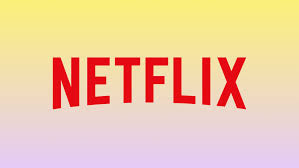

<h2>Dataset Content</h2>
<p>This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.</p>
<ul>Inspiration
    <li>Understanding what content is available in different countries</li>
    <li>Identifying similar content by matching text-based features</li>
    <li>Network analysis of Actors / Directors and find interesting insights</li>
    <li>Is Netflix has increasingly focusing on TV rather than movies in recent years.</li>
</ul>

In [74]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/netflix-shows/netflix_titles.csv


In [75]:
df=pd.read_csv('../input/netflix-shows/netflix_titles.csv')
print('Done!')

Done!


<h1>Data Investigation</h1>

In [76]:
def data_inv(df):
    print('netflix movies and shows: ',df.shape[0])
    print('dataset variables: ',df.shape[1])
    print('-'*10)
    print('dateset columns: \n')
    print(df.columns)
    print('-'*10)
    print('data-type of each column: \n')
    print(df.dtypes)
    print('-'*10)
    print('missing rows in each column: \n')
    c=df.isnull().sum()
    print(c[c>0])
data_inv(df)

netflix movies and shows:  8807
dataset variables:  12
----------
dateset columns: 

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')
----------
data-type of each column: 

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object
----------
missing rows in each column: 

director      2634
cast           825
country        831
date_added      10
rating           4
duration         3
dtype: int64


<h1>Data Cleaning</h1>

<ul>
    <li>Drop id column</li>
    <li>Drop dublicate shows</li>
    <li>create a new column shows the number of cast in each row</li>
    <li>we have 10 missing rows in rating column, replace them by the mode</li>
    <li>for the missing rows in added_date column, replace them by January 1,{release_year}</li>
    <li>I think we can not replace missing rows in column country by other countries, but we can use genre to <br>
        identify this country ex: replace missing rows by japan for Anime</li>
    <li>convert the date_added column from object type to datetime</li>
</ul>

In [77]:
dups=df.duplicated(['title','country','type','release_year'])
df[dups]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


In [78]:
df=df.drop_duplicates(['title','country','type','release_year'])

In [79]:
df=df.drop('show_id',axis=1)

In [80]:
df['cast']=df['cast'].replace(np.nan,'Unknown')
def cast_counter(cast):
    if cast=='Unknown':
        return 0
    else:
        lst=cast.split(', ')
        length=len(lst)
        return length
df['number_of_cast']=df['cast'].apply(cast_counter)
df['cast']=df['cast'].replace('Unknown',np.nan)

In [81]:
df=df.reset_index()

In [82]:
df['rating']=df['rating'].fillna(df['rating'].mode()[0])

In [83]:
df['date_added']=df['date_added'].fillna('January 1, {}'.format(str(df['release_year'].mode()[0])))

In [84]:
for i,j in zip(df['country'].values,df.index):
    if i==np.nan:
        if ('Anime' in df.loc[j,'listed_in']) or ('anime' in df.loc[j,'listed_in']):
                df.loc[j,'country']='Japan'
        else:
            continue
    else:
        continue

In [85]:
import re
months={
    'January':1,
    'February':2,
    'March':3,
    'April':4,
    'May':5,
    'June':6,
    'July':7,
    'August':8,
    'September':9,
    'October':10,
    'November':11,
    'December':12
}
date_lst=[]
for i in df['date_added'].values:
    str1=re.findall('([a-zA-Z]+)\s[0-9]+\,\s[0-9]+',i)
    str2=re.findall('[a-zA-Z]+\s([0-9]+)\,\s[0-9]+',i)
    str3=re.findall('[a-zA-Z]+\s[0-9]+\,\s([0-9]+)',i)
    date='{}-{}-{}'.format(str3[0],months[str1[0]],str2[0])
    date_lst.append(date)

In [86]:
df['date_added_cleaned']=date_lst

In [87]:
df=df.drop('date_added',axis=1)

In [88]:
df['date_added_cleaned']=df['date_added_cleaned'].astype('datetime64[ns]')

<h1>Exploratory Data Analysis</h1>

<p>now, it is time to answer some questions.</p>
<ul>
    <li>Understand every category in rating column(Google it)</li>
    <li>Understanding what content is available in different countries.</li>
    <li>Is Netflix has increasingly focusing on TV rather than movies in recent years.</li>
    <li>The most observed rating categories in TV-shows and Movies </li>
    <li>Identifying similar content by matching text-based features</li>
    <li>How many content its release year differ from its year added</li>
</ul>

<p>let's now google the categories and explore them</p>
<ul>
    <li>TV-MA:This program is specifically designed to be viewed by adults and therefore may be unsuitable for children under 17.</li>
    <li>TV-14:This program contains some material that many parents would find unsuitable for children under 14 years of age.</li>
    <li>TV-PG:This program contains material that parents may find unsuitable for younger children.</li>
    <li>R:Under 17 requires accompanying parent or adult guardian,Parents are urged to learn more about the film before taking their young children with them.</li>
    <li>PG-13:Some material may be inappropriate for children under 13. Parents are urged to be cautious. Some material may be inappropriate for pre-teenagers.</li>
    <li>NR or UR:If a film has not been submitted for a rating or is an uncut version of a film that was submitted</li>
    <li>PG:Some material may not be suitable for children,May contain some material parents might not like for their young children.</li>
    <li>TV-Y7:This program is designed for children age 7 and above.</li>
    <li>TV-G:This program is suitable for all ages.</li>
    <li>TV-Y:Programs rated TV-Y are designed to be appropriate for children of all ages. The thematic elements portrayed in programs with this rating are specifically designed for a very young audience, including children ages 2-6.</li>
    <li>TV-Y7-FV:is recommended for ages 7 and older, with the unique advisory that the program contains fantasy violence.</li>
    <li>G:All ages admitted. Nothing that would offend parents for viewing by children.</li>
    <li>NC-17:No One 17 and Under Admitted. Clearly adult. Children are not admitted.</li>
</ul>

<p> here we discover that UR and NR is the same rating(unrated,Not rated)<br>Uncut/extended versions of films that are labeled "Unrated" also contain warnings saying that the uncut version of the film contains content that differs from the theatrical release and might not be suitable for minors.<br> so we have the fix this. </p>

In [89]:
for i in df.index:
    if df.loc[i,'rating']=='UR':
        df.loc[i,'rating']='NR'

<p>Now we fix this problem by replace UR category by NR.</p>

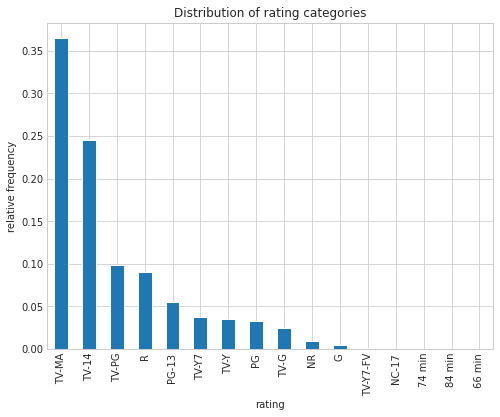

In [90]:
plt.figure(figsize=(8,6))
df['rating'].value_counts(normalize=True).plot.bar()
plt.title('Distribution of rating categories')
plt.xlabel('rating')
plt.ylabel('relative frequency')
plt.show()

<p><p> after expecting the distribution of rating ctegories, it is abvious that TV-MA is the mode<br>
    TV-14 comes in the second place and so on...<br></p>

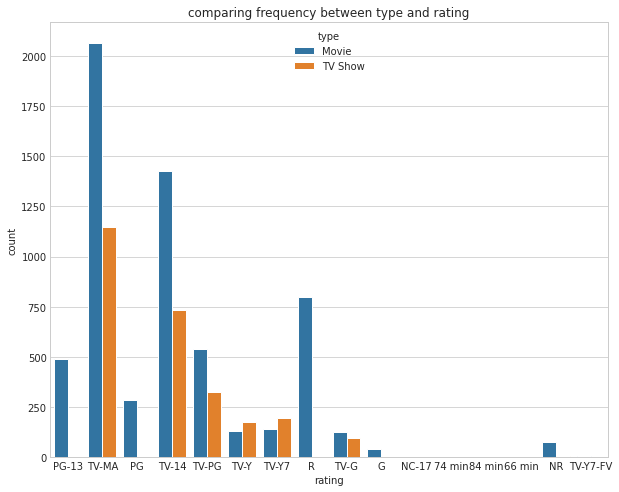

In [91]:
plt.figure(figsize=(10,8))
sns.countplot(x='rating',hue='type',data=df)
plt.title('comparing frequency between type and rating')
plt.show()

<p>We can say that Movies is the majority category in every rating category on Netflix, except(TV-Y,TV-Y7,TV-Y7-FV).</p> 

In [92]:
df['country'].value_counts().sort_values(ascending=False)

United States                                           2818
India                                                    972
United Kingdom                                           419
Japan                                                    245
South Korea                                              199
                                                        ... 
Ireland, United Kingdom, Greece, France, Netherlands       1
France, Canada, Italy, United States, China                1
United States, Venezuela                                   1
United Kingdom, Canada, Japan                              1
United Arab Emirates, Jordan                               1
Name: country, Length: 748, dtype: int64

<p>we have huge number of countries in country column so we will focus on (United States,India,United Kingdom,Japan,Canada,Spain)</p>

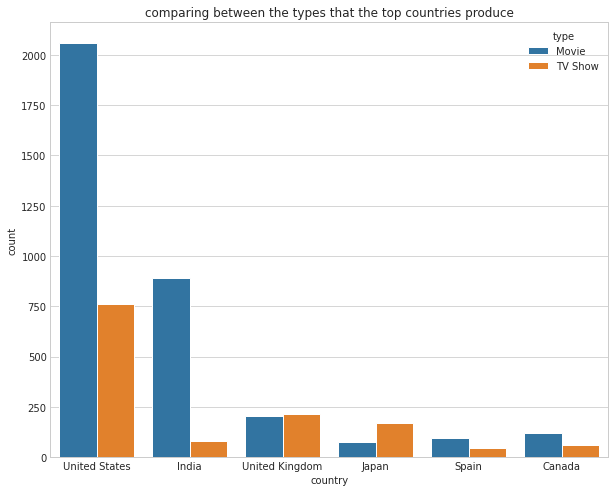

In [93]:
top_productive_countries=df[(df['country']=='United States')|(df['country']=='India')|(df['country']=='United Kingdom')|(df['country']=='Japan')|
                             (df['country']=='Canada')|(df['country']=='Spain')]
plt.figure(figsize=(10,8))
sns.countplot(x='country',hue='type',data=top_productive_countries)
plt.title('comparing between the types that the top countries produce')
plt.show()

<p>UK and Japan produces TV-Shows more than Movies</p>

In [94]:
for i in top_productive_countries['country'].unique():
    print(i)
    print(top_productive_countries[top_productive_countries['country']==i]['rating'].value_counts(normalize=True)*100)
    print('-'*10)

United States
TV-MA       32.931157
R           15.613911
TV-14       14.407381
PG-13       10.255500
TV-PG        8.907026
PG           5.819730
TV-Y7        3.584102
TV-Y         3.087296
TV-G         2.909865
NR           1.277502
G            1.029099
74 min       0.035486
84 min       0.035486
66 min       0.035486
TV-Y7-FV     0.035486
NC-17        0.035486
Name: rating, dtype: float64
----------
India
TV-14       56.584362
TV-MA       25.514403
TV-PG       13.786008
TV-Y7        1.440329
TV-G         0.925926
TV-Y         0.514403
PG-13        0.411523
NR           0.411523
PG           0.205761
R            0.102881
TV-Y7-FV     0.102881
Name: rating, dtype: float64
----------
United Kingdom
TV-MA    42.243437
TV-PG    17.899761
TV-14    17.183771
R         7.875895
TV-G      5.489260
TV-Y      4.534606
PG-13     1.909308
TV-Y7     1.193317
NR        1.193317
PG        0.477327
Name: rating, dtype: float64
----------
Japan
TV-14    37.142857
TV-MA    35.918367
TV-PG    15.91836

<p>now let's see if Netflix focuse on TV rather than movies in recent years(2017-2018-2019)</p>

In [95]:
df['year_added']=df['date_added_cleaned'].dt.year

In [96]:
df['type'].value_counts(normalize=True)

Movie      0.696151
TV Show    0.303849
Name: type, dtype: float64

<p>relative freuency of movies still has the lead</p>

In [97]:
df.groupby('year_added')['type'].value_counts(normalize=True)*100

year_added  type   
2008        Movie       50.000000
            TV Show     50.000000
2009        Movie      100.000000
2010        Movie      100.000000
2011        Movie      100.000000
2012        Movie      100.000000
2013        Movie       54.545455
            TV Show     45.454545
2014        Movie       79.166667
            TV Show     20.833333
2015        Movie       68.292683
            TV Show     31.707317
2016        Movie       58.974359
            TV Show     41.025641
2017        Movie       70.622896
            TV Show     29.377104
2018        Movie       74.562990
            TV Show     25.437010
2019        Movie       70.634921
            TV Show     29.365079
2020        Movie       68.334220
            TV Show     31.665780
2021        Movie       66.288385
            TV Show     33.711615
Name: type, dtype: float64

<p>We can say that Netflix begin to focus on TV-Shows,but Movies still has the lead in evey year.</p>

In [99]:
dups=df.duplicated(['title'])
df[dups]['title']

Series([], Name: title, dtype: object)

<p>this titles have one or more contents</p>

In [100]:
for i in df[dups]['title'].values:
    print(df[df['title']==i][['title','type','release_year','country']])
    print('-'*40)

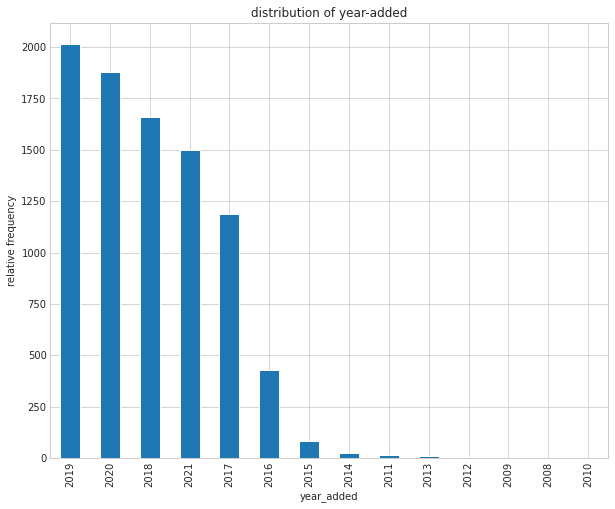

In [101]:
plt.figure(figsize=(10,8))
df['year_added'].value_counts().plot.bar()
plt.title('distribution of year-added')
plt.ylabel('relative frequency')
plt.xlabel('year_added')
plt.show()

<p>2018 is remarkable year for netflix</p>

In [102]:
counts=0
for i,j in zip(df['release_year'].values,df['year_added'].values):
    if i!=j:
        counts+=1
print('number of contents that its release year differ from the year added to netflix are ',str(counts))

number of contents that its release year differ from the year added to netflix are  5565
